## Analysing the peak results from a hot-deformation experiment

In [21]:
import pathlib
import re

# from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.signal import medfilt

In [2]:
pwd

'/Users/mbcx9cd4/Documents/GitHub/Continuous-Peak-Fit/Ti64'

### Extracting the peak profile data

Use the `read_fit_results` function to get the results from the .fit files.

In [3]:
def read_fit_results (experiment_number: int, start: int, end: int):
    """This function loops through refined '.fit' files produced using
    the python package Continuous-Peak-Fit and searches for the peak position, 
    intensity, half-width and Pseudo-Voigt weighting results. 
    
    :param experiment_number: input experiment number.
    :param start: first file number.
    :param end: last file number.
    
    :return: peak position, peak intensity, peak half-width and peak Pseudo-Voigt weighted fraction
    as nested dictionaries.
    """

    # define dictionaries to save results to
    peak_position = dict()
    peak_intensity = dict()
    peak_halfwidth = dict()
    peak_PV_weight = dict()

    for test_number in range (start,end):
        # input fit results file
        input_path = f'results/{experiment_number:03d} results/pixium_{test_number:05d}.fit'

        # dictionary to save results to
        peak_position[test_number] = dict()
        peak_intensity[test_number] = dict()
        peak_halfwidth[test_number] = dict()
        peak_PV_weight[test_number] = dict()

        with open(input_path, 'r') as results_file:  
            line = results_file.readline()
            peak_number = 1

            while line:
                if '# peak number' in line:
                    peak_position[test_number][peak_number]=[]
                    peak_intensity[test_number][peak_number]=[]
                    peak_halfwidth[test_number][peak_number]=[]
                    peak_PV_weight[test_number][peak_number]=[]

                    for azimuth_degree in range (0, 360):
                        line = results_file.readline()
                        fit_result = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                        peak_position[test_number][peak_number].append(float(fit_result[0]))
                        peak_intensity[test_number][peak_number].append(float(fit_result[1]))
                        peak_halfwidth[test_number][peak_number].append(float(fit_result[2]))
                        peak_PV_weight[test_number][peak_number].append(float(fit_result[3]))

                    peak_number+=1

                else:
                    line = results_file.readline()

    return peak_position, peak_intensity, peak_halfwidth, peak_PV_weight

In [4]:
experiment_number = 65
start = 3100
end = 3318

peak_position, peak_intensity, peak_halfwidth, peak_PV_weight = read_fit_results(experiment_number,start,end)

Write the peak results to new arrays to plot the behaviour of single lattice plane peaks over time.

In [5]:
def reorder_fit_results (start: int, end: int, peak_label: list, 
                         peak_position: dict, peak_intensity: dict, peak_halfwidth: dict, peak_PV_weight: dict):
    """This function returns the peak data of specific lattice planes,
    at specific azimuthal angles. The peak data is captured from the nested 
    dictionaries containing the peak position, intensity, half-width and 
    Pseudo-Voigt weighting results and written to new dictionaries.
    
    :param start: first file number.
    :param end: last file number.
    :param peak_number: list of the peak numbers as they are labelled in the .fit file, starting at 1.
    :peak_label: list of lattice plane labels.
    :peak_position: dictionary of the peak positions for all peaks, at all azimuthal angles, for different files.
    :peak_intensity: dictionary of the peak intensities for all peaks, at all azimuthal angles, for different files.
    :peak_halfwidth: dictionary of the peak half-widths for all peaks, at all azimuthal angles, for different files.
    :peak_PV_weight: dictionary of the peak Pseudo-Voigt weighted fractions for all peaks, at all azimuthal angles, 
                     for different files.
    
    :return: test number, peak position, peak intensity, peak half-width and peak Pseudo-Voigt weighted fraction
    as nested dictionaries.
    """
    
    test_number = list(range(start,end+1))
    peak_number = list(range(1, len(peak_label)+1))
    
    peak_position_time = dict()
    peak_intensity_time = dict()
    peak_halfwidth_time = dict()
    peak_PV_weight_time = dict()

    for number, label in zip(peak_number,peak_label):
        peak_position_time[label]=[]
        peak_intensity_time[label]=[]
        peak_halfwidth_time[label]=[]
        peak_PV_weight_time[label]=[]

        for test in test_number:
            peak_position_time[label].append(peak_position[test][number][azimuth_degree])
            peak_intensity_time[label].append(peak_intensity[test][number][azimuth_degree])
            peak_halfwidth_time[label].append(peak_halfwidth[test][number][azimuth_degree])
            peak_PV_weight_time[label].append(peak_PV_weight[test][number][azimuth_degree])
    
    return(test_number,peak_position_time,peak_intensity_time,peak_halfwidth_time,peak_PV_weight_time)

In [6]:
azimuth_degree = 90
peak_label = ['(10-10)','(0002)','(110)','(10-11)','(10-12)','(200)','(11-20)','(10-13)','(20-20)','(11-22)','(20-21)','(0004)','(220)','(20-22)']

test_number,peak_position_time,peak_intensity_time,peak_halfwidth_time,peak_PV_weight_time = reorder_fit_results(start, end, 
                                                    peak_label, peak_position, peak_intensity, peak_halfwidth, peak_PV_weight)

### Synchronise the ETMT data

In [7]:
def plot_instrument_data(file_path_instrument_data: str, start_deform: int, end_deform: int, 
                         load_conversion: int = 25, temp_conversion: int = 150, position_conversion = 0.5): 
    
    """ Plot load, temperature and position data, from instrument data recorded for each diffraction pattern image.
    The instrument data is in the form of an analogue voltage signal, with a conversion factor used to calculate 
    the Newtons, Degree Celsius or Millimetre values to plot.
    
    :param file_path_instrument_data: input file path string.
    :param start_deform: value defining the start point of deformation.
    :param end_deform: value defining the end point of deformation.
    :param load_conversion: conversion for load in Newton / Volt (default is 25).
    :param temp_conversion: conversion for temperature in Degree Celsius / Volt (default is 150).
    :param position_conversion: conversion for position in Millimetres / Volt  (default is 0.5).
    
    :return: length of the instrument data (equivalent to the maximum frame).
    """ 
    
    instrument_data = np.loadtxt(file_path_instrument_data, skiprows=6)
    max_frame=len(instrument_data)

    load = instrument_data[:, 1] * load_conversion
    temperature = instrument_data[:, 2] * temp_conversion
    position = instrument_data[:, 3] * position_conversion

    plt.plot(instrument_data[:, 0], temperature)
    plt.xlabel("Frame_number")
    plt.ylabel("Temperature (°C)")
    plt.show()

    plt.plot(instrument_data[:, 0], position)
    plt.xlabel("Frame_number")
    plt.ylabel("ETMT Gauge Position")
    plt.show()

    plt.plot(instrument_data[start_deform:end_deform, 0], load[start_deform:end_deform])
    plt.xlabel("Frame_number")
    plt.ylabel("Load (N)")
    plt.show()
    
    return max_frame

In [8]:
def plot_ETMT_data(file_path_etmt_data: str, number_deform_frames: int, first_point: int, last_point: int,
                  acquisition_freq_sxrd: int = 10, acquisition_freq_etmt: int = 50, filter_data: int = 0):
    """ Plot true stress, true stress versus true strain, and true stress versus true strain at an adjusted frequency
    from data recorded at the ETMT.
    
    :param file_path_etmt_data: input file path string.
    :param first_point: value defining the start point of deformation.
    :param last_point: value defining the end point of deformation.
    :param acquisition_freq_sxrd: acquisition frequency of the SXRD detector in Hz (default is 10 Hz).
    :param acquisition_freq_etmt: cacquisition frequency of the ETMT data recorder in Hz (default is 50 Hz).
    :param filter_data: size of the median filter window to filter the data with medfilt function (default is ).
    
    :return: NumPy arrays for the true stress and true strain.
    """

    etmt_data = np.loadtxt(file_path_etmt_data, delimiter=',', skiprows=1)

    acquisition_frequency_ratio = int(acquisition_freq_etmt / acquisition_freq_sxrd)
    print(acquisition_frequency_ratio)
    end_deform_point = int(acquisition_frequency_ratio * number_deform_frames)
    
    data_load = etmt_data[first_point-1:last_point, 0]
    data_strain = etmt_data[first_point-1:last_point, 3]
    data_stress = etmt_data[first_point-1:last_point, 4]

    # some filtering of the data is needed due to fluctuations in the ETMT data
    filter_strain = medfilt(data_strain,filter_data)
    filter_stress = medfilt(data_stress,filter_data)
    
    # plot the true stress for each point in the ETMT data
    plt.plot(filter_stress[0:end_deform_point],'-o', color='blue',markersize=10)
    plt.title('ETMT Data')
    plt.ylabel('True Stress, ${\sigma}$ (MPa)')
    plt.xlabel('ETMT Data Number')
    plt.show()
    
    # plot the true stress versus true strain at the ETMT acquisition frequency
    plt.plot(filter_strain[0:end_deform_point],filter_stress[0:end_deform_point],'-o',color='blue', markersize=10)
    plt.title('ETMT Data')
    plt.ylabel('True Stress, ${\sigma}$ (MPa)')
    plt.xlabel('True Strain, ${\epsilon}$')
    plt.show()
    
    # plot the true stress versus true strain, with each point representing a diffraction pattern image
    true_strain=np.empty([number_deform_frames,])
    true_stress=np.empty([number_deform_frames,])
    for image in range(0, number_deform_frames):
        true_strain[image]=filter_strain[image*acquisition_frequency_ratio]
        true_stress[image]=filter_stress[image*acquisition_frequency_ratio]  
    
    plt.plot(true_strain, true_stress, 'o',color='blue', markersize=10)
    plt.title('ETMT Data at Adjusted Frequency')
    plt.ylabel('True Stress, $\sigma$ (MPa)')
    plt.xlabel('True Strain, $\epsilon$')
    plt.show()
    
    return (true_stress, true_strain)

Load the instrument data (ETMT analogue output) recorded with each of the diffraction pattern images and determine the exact start/end of the deformation:

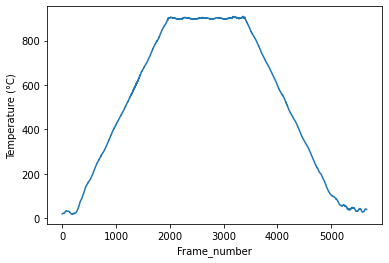

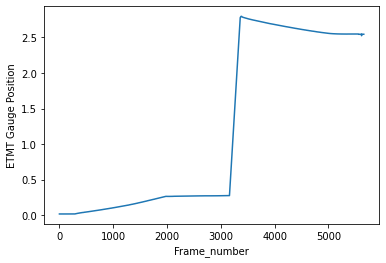

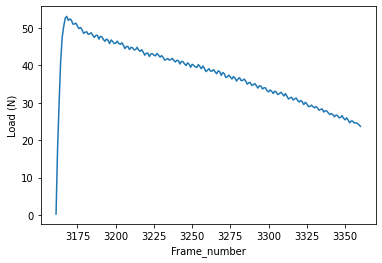

5657

In [9]:
file_path_instrument_data = "data/image_load_files_for_DAWN/adc_065_TI64_NDload_900C_15mms.dat"

# change this value until the load is zero, this will determine the start (and end) point of deformation
start_deform = 3160

# set the applied deformation speed in mm/s
deform_speed = 0.15
# set the end position in mm
final_deform_position = 3

# set the acquisition frequency of the SXRD detector (and the instrument data) in Hz
acquisition_freq_sxrd = 10
# set the acquisition frequency of data recorded on the ETMT in Hz
acquisition_freq_etmt = 50

# calculate the number of frames (individual measurements) during deformation
number_deform_frames = int((final_deform_position / deform_speed) * acquisition_freq_sxrd)
# calculate the end point (final frame) of deformation
end_deform = int(start_deform + number_deform_frames)

# plot the instrument data (ETMT analogue output)
plot_instrument_data(file_path_instrument_data, start_deform, end_deform)

Load the true stress-strain data recorded on the ETMT. True stress and strain are calculated using the resistance method in a previous notebook. The data has already been reduced to start at the point of applied load.

The `plot_ETMT_data` function in the `analysis_functions` returns arrays of the true stress and true strain at the adjusted acquisition frequency of the recorded diffraction pattern images.

5


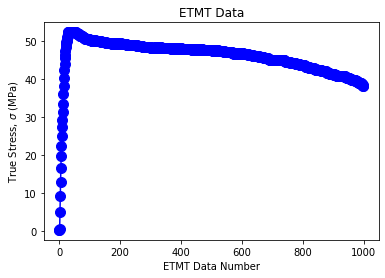

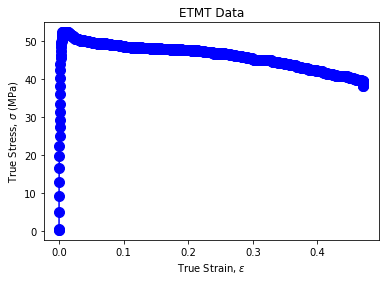

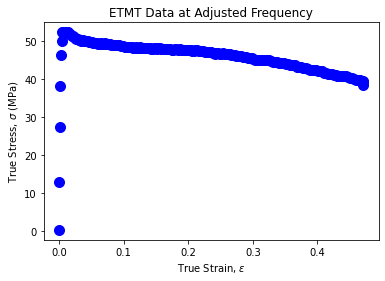

In [10]:
file_path_etmt_data = 'data/ETMT data/065 ETMT.txt'

first_point = 1
last_point = 1000

filter_data = 45

true_stress, true_strain = plot_ETMT_data(file_path_etmt_data, number_deform_frames, first_point, last_point, acquisition_freq_sxrd, 
                                          acquisition_freq_etmt, filter_data)

### Set the colour and marker scheme

Colour and marker scheme:

Alpha phase uses discretised viridis colour scheme, calculated using `colour_range`:

In [18]:
def colour_range(N: int = 9, colour_map: str = 'viridis'):
    """ Return a range of hex colour codes for a particular colour map.
    
    :param N: number of desired colour codes (default is 9).
    :param colour_map: type of colour map (default is 'viridis').
    :return: list of hex colour codes
    """
    base = plt.cm.get_cmap(colour_map)
    colour_list = base(np.linspace(0, 1, N))
    colour_hex_list=[]
    for i in range (N-1, -1, -1):
         colour_hex_list.append(colors.rgb2hex(colour_list[i]))
    
    return colour_hex_list

In [22]:
N=9
colour_range(N)

['#fde725',
 '#addc30',
 '#5ec962',
 '#28ae80',
 '#21918c',
 '#2c728e',
 '#3b528b',
 '#472d7b',
 '#440154']

Beta phase uses adjusted colour scheme from https://learnui.design/tools/data-color-picker.html#palette with 7 colours chosen.

This gives the combined colour scheme for each lattice plane:

In [24]:
plane_colour = {
'(10-10)' : '#fde725',
'(0002)' : '#addc30',
'(10-11)' : '#5ec962',
'(10-12)' : '#28ae80',
'(11-20)' : '#21918c',
'(10-13)' : '#2c728e',
'(20-20)' : '#3b528b',
'(11-22)' : '#472d7b',
'(20-21)' : '#440154',
'(110)' : '#ff764a',
'(200)' : '#ef5675',
'(211)' : '#bc5090',
'(220)' : '#ffa600',
}

The marker scheme for each lattice plane is given here:

In [25]:
plane_marker = {
'(10-10)' : 's', #square
'(0002)' : 'H', #hexagon
'(10-11)' : '^', #ltriangle - up
'(10-12)' : 'v', #ytriangle - down
'(11-20)' : 'D', #diamond
'(10-13)' : '<', #triangle - left
'(20-20)' : 'd', #thin diamond
'(11-22)' : '*', #star
'(20-21)' : 'o', #circle
'(110)' : '+', #plus
'(200)' : 'x', #cross
'(211)' : 'X', #cross (filled)
'(220)' : 'P', #plus (filled)
}

### Analysing the peak changes

These functions are used for analysing the data.

In [11]:
def calc_dspacing(two_theta: float, x_ray_energy: float = 89.07) -> float:
    """ Calculate d-spacing from 2-theta values using Bragg's law.
    
    :param two_theta: 2-theta value in degrees.
    :param x_ray_energy: X-ray energy in keV (default is 89.07 keV).
    :return: d-spacing in metres.
    """ 
    c = 2.99792458e8
    h = 6.62607004e-34
    e = 1.6021766208e-19
    x_ray_wavelength = (h * c) / (x_ray_energy * 1e3 * e)
    dspacing = x_ray_wavelength / (2 * np.sin(np.array(two_theta) * np.pi / 360))
    
    return dspacing

def calc_strain(two_theta: np.ndarray, zero_range: int = 1) -> np.ndarray:
    """ Calculate strain from 2-theta values.
    
    :param two_theta: 2-theta value in degrees.
    :param zero_range: Integer used to define a range of points to calculate an average initial 2-theta value
                       (default is 1).
    :return: NumPy array of strain values in degrees.
    """ 
    two_theta = 0.5 * (np.array(two_theta)) * np.pi / 180.0
    two_theta_0 = np.mean(two_theta[0:zero_range])
    print(two_theta_0)
    strain = - (two_theta - two_theta_0) / np.tan(two_theta)
    
    return strain

def relative_amplitude(amplitude: np.ndarray) -> np.ndarray:
    """ Divide an array of amplitude values by the first value in the array.
    
    :param amplitude: NumPy array of amplitude float values.
    :return: NumPy array of float values.
    """ 
    relative_amplitude = np.array(amplitude) / amplitude[0]
    
    return relative_amplitude

Reduce the peak labels to plot just the important peaks.

In [13]:
peak_label_reduced = ['(10-10)','(0002)','(110)','(200)','(11-20)','(220)']

Plot the change in microstrain over time.

0.02726378824540342
0.02949780968795616
0.0299803932261326
0.042415864146592194
0.04720679294331663
0.05999482037267908


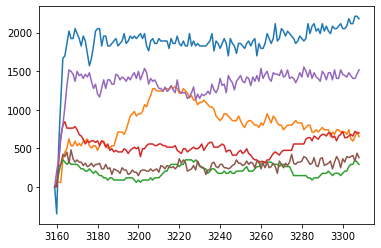

In [50]:
start_deform = 3159
number_deform_points = 150
zero_point = 3100

end_deform = start_deform + number_deform_points
start_deform_index = start_deform - zero_point
end_deform_index = end_deform - zero_point

test_number_reduced = np.array(test_number[(start_deform_index):(end_deform_index)])
for peak_name in peak_label_reduced:
    peak_position_time_array = np.array(peak_position_time[peak_name])
    microstrain = calc_strain(peak_position_time_array[(start_deform_index):(end_deform_index)])*1e6
    plt.plot(test_number_reduced,microstrain)  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.02726378824540342
0.02949780968795616
0.0299803932261326
0.042415864146592194
0.04720679294331663
0.05999482037267908


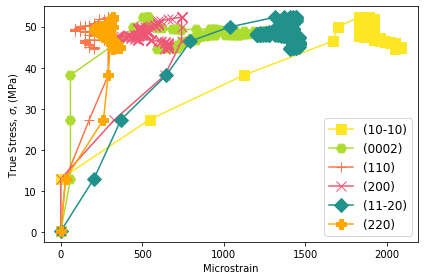

In [56]:
for peak_name in peak_label_reduced:
    peak_position_time_array = np.array(peak_position_time[peak_name])
    microstrain = calc_strain(peak_position_time_array[(start_deform_index):(end_deform_index)])*1e6
    microstrain = medfilt(microstrain,15)
    plt.plot(microstrain,true_stress[0:number_deform_points],marker=plane_marker[peak_name],color=plane_colour[peak_name],markersize=10,label=peak_name)
    plt.legend(fontsize=12)
    plt.ylabel('True Stress, ${\sigma}$, (MPa)')
    plt.xlabel('Microstrain')
    
plt.tight_layout()
save_plot_path='results/' + '065' + '_strain_partitioning.eps'
plt.savefig(save_plot_path, format='eps')

### Comparing microstrain of xrdfit and CPF